In [1]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 99.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    F

In [2]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"


In [4]:
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis --unzip


100% 1.74G/1.74G [01:19<00:00, 23.4MB/s]
100% 1.74G/1.74G [01:19<00:00, 23.5MB/s]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

# As the dataset is divided into folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
w,h = 400,400
batch_size = 32

train_path = './train'
test_path = './test'
val_path = './val'

train_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    zoom_range=0.3
)

test_img_gen = ImageDataGenerator(
    rescale = 1.0/255
)

val_img_gen = ImageDataGenerator(
    rescale = 1.0/255
)

train_dataset = train_img_gen.flow_from_directory(
    train_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_dataset = test_img_gen.flow_from_directory(
    test_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_dataset = val_img_gen.flow_from_directory(
    val_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [7]:
train_dataset.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}

(32, 400, 400, 3)


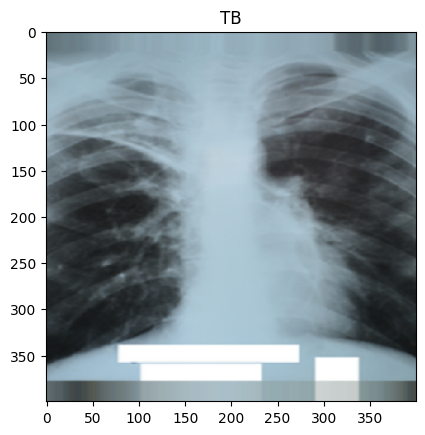

(32, 400, 400, 3)


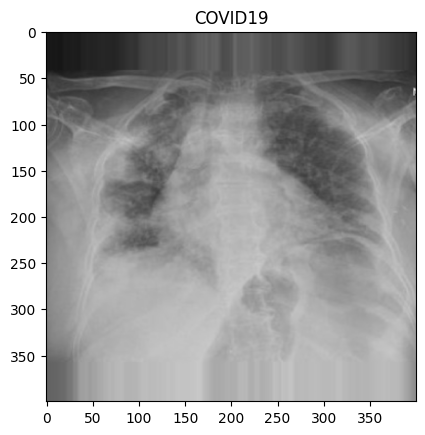

(32, 400, 400, 3)


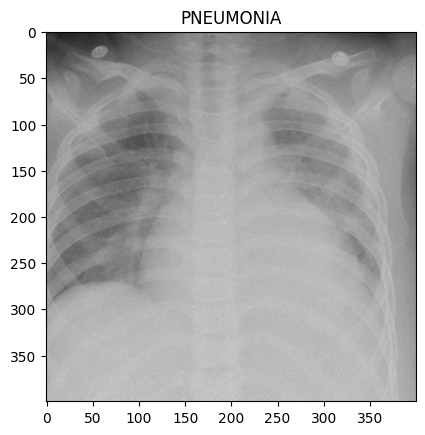

(32, 400, 400, 3)


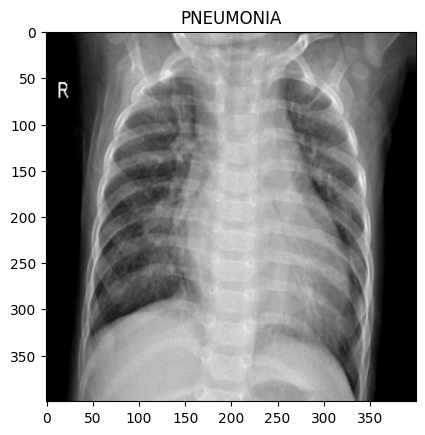

(32, 400, 400, 3)


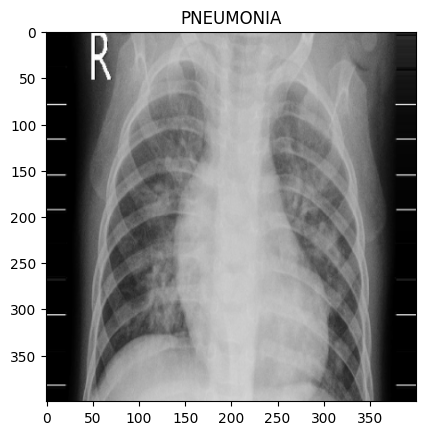

In [10]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TB']

for _ in range(5):
    idx = np.random.randint(len(train_dataset))
    img, label = train_dataset[idx]
    print(img.shape)
    plt.title(classes[np.argmax(label[0])])
    plt.imshow(img[0])
    plt.show()

In [11]:
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(w, h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # dropout to avoid overfitting
model.add(layers.Dense(4, activation='softmax'))  # softmax is used as it is a multiclass problem

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 398, 398, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 199, 199, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 197, 197, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 98, 98, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 294912)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      37,748,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,900,612 (144.58 MB)

 Trainable params: 37,900,612 (144.58 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
resnetModel = models.Sequential()

ResNet_101_V2 = tf.keras.applications.ResNet101V2(
                include_top = False,
                weights="imagenet",
                input_shape=(w,h,3),
                pooling='max',
                classes=4
            )

for layer in ResNet_101_V2.layers:
    layer.trainable = False

resnetModel.add(ResNet_101_V2)
resnetModel.add(layers.Flatten())
resnetModel.add(layers.Dense(512, activation='relu'))
resnetModel.add(layers.Dense(4, activation='softmax'))  # softmax is used as it is a multiclass problem

# Compile the model
resnetModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

resnetModel.summary()

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ ?                           │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,626,560 (162.61 MB)

In [32]:
# Save best model
weight_path = './working/'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path+'RESNET.weights.h5',
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy'
)

In [33]:
history = resnetModel.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[model_checkpoint])

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.7214 - loss: 7.3816 - val_accuracy: 0.7895 - val_loss: 0.3942
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.8961 - loss: 0.4284 - val_accuracy: 0.7632 - val_loss: 0.7425
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.9192 - loss: 0.2829 - val_accuracy: 0.8158 - val_loss: 0.4644
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9347 - loss: 0.1985 - val_accuracy: 0.8421 - val_loss: 0.3869
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.9182 - loss: 0.2432 - val_accuracy: 0.8684 - val_loss: 0.5056
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.9346 - loss: 0.1731 - val_accuracy: 0.8421 - val_loss: 0.3121
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9514 - loss: 0.1367 - val_accuracy: 0.8947 - val_loss: 0.4220
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9470 - loss: 0.1562 - val_accu

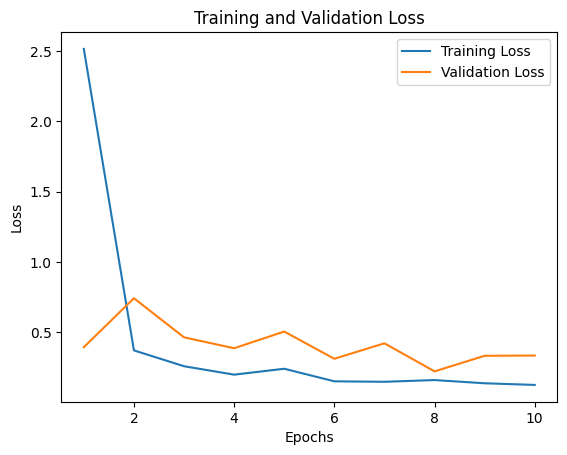

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(history.history['loss'])
# Plot the loss and val_loss
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [36]:
# load best weights to model
resnetModel.load_weights(weight_path+'RESNET.weights.h5')

# make predictions
predictions = resnetModel.predict(test_dataset)
predictions

25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step


array([[9.9992919e-01, 2.0684134e-07, 7.0542381e-05, 2.3325229e-11],
       [8.2998192e-01, 6.2409337e-05, 1.6995572e-01, 5.9467625e-11],
       [9.9975461e-01, 1.0461681e-04, 1.3955141e-04, 1.2718909e-06],
       ...,
       [1.5170320e-07, 9.4319092e-15, 6.3391493e-11, 9.9999988e-01],
       [1.3184507e-04, 3.9973205e-10, 1.5278644e-07, 9.9986804e-01],
       [3.0418252e-05, 2.2587174e-14, 1.0204716e-09, 9.9996960e-01]],
      dtype=float32)

In [37]:
# we have to get the position of the maximum value from each sample.

predicted_class = np.argmax(predictions, axis=1)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       106
           1       0.82      0.92      0.87       234
           2       0.94      0.88      0.91       390
           3       0.97      0.93      0.95        41

    accuracy                           0.90       771
   macro avg       0.92      0.92      0.92       771
weighted avg       0.91      0.90      0.90       771

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}


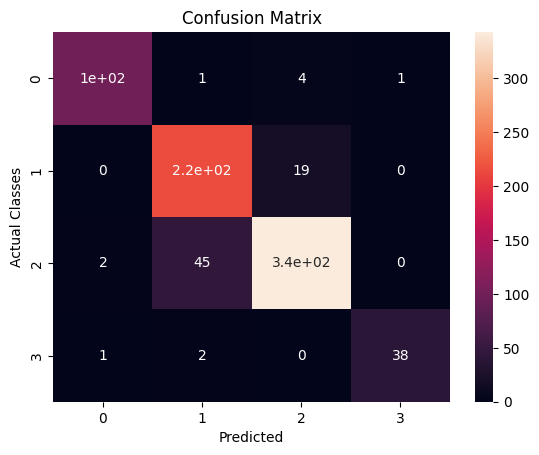

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_dataset.classes

sns.heatmap(confusion_matrix(true_labels, predicted_class), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_class))
print(test_dataset.class_indices)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [39]:
resnetModel.save_weights("./resnet_model.weights.h5")

resnetModel.save("./resnet_model.keras")


In [41]:
from google.colab import files
files.download("resnet_model.weights.h5")
files.download("resnet_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import tensorflow as tf

# Clear the current TensorFlow graph.
tf.keras.backend.clear_session()

# Optionally, you can also manually delete the model if you have it stored in a variable.
# del model

print("GPU resources should be freed up now.")


GPU resources should be freed up now.


In [24]:
# Save best model
weight_path = './working/'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path+'.weights.h5',
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy'
)

In [15]:
historyCNN = model.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=[model_checkpoint])

Epoch 1/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6176 - loss: 1.2470 - val_accuracy: 0.6316 - val_loss: 0.9413
Epoch 2/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.7991 - loss: 0.5440 - val_accuracy: 0.7368 - val_loss: 0.5630
Epoch 3/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.8486 - loss: 0.4183 - val_accuracy: 0.8158 - val_loss: 0.6260
Epoch 4/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.8638 - loss: 0.3940 - val_accuracy: 0.7368 - val_loss: 0.8076
Epoch 5/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.8657 - loss: 0.3930 - val_accuracy: 0.8421 - val_loss: 0.5202
Epoch 6/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.8379 - loss: 0.4374 - val_accuracy: 0.7105 - val_loss: 1.4744
Epoch 7/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.8849 - loss: 0.3387 - val_accuracy: 0.8158 - val_loss: 1.2527
Epoch 8/15
198/198 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.8970 - loss: 0.3165 - val_accu

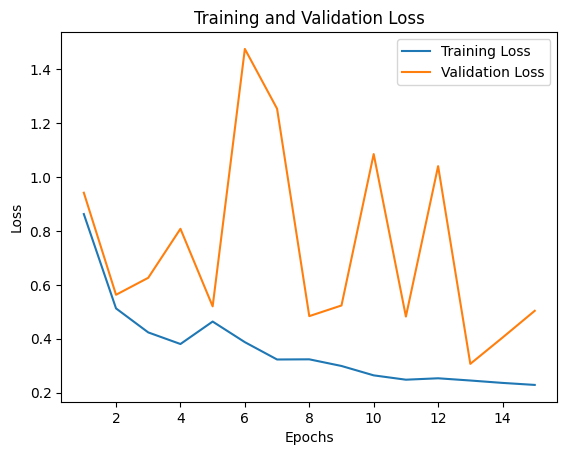

In [16]:
loss = historyCNN.history['loss']
val_loss = historyCNN.history['val_loss']
epochs = len(historyCNN.history['loss'])
# Plot the loss and val_loss
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [20]:
# load best weights to model
model.load_weights(weight_path+'.weights.h5')

# make predictions
CNNpredictions = model.predict(test_dataset)
CNNpredictions

25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 506ms/step


array([[9.7452152e-01, 4.3057296e-03, 1.9505380e-02, 1.6673591e-03],
       [7.8733599e-01, 3.1922082e-03, 7.7260382e-02, 1.3221145e-01],
       [5.0136244e-01, 9.0580033e-05, 6.9986731e-02, 4.2856023e-01],
       ...,
       [3.1320881e-02, 1.0640178e-03, 1.1672478e-02, 9.5594263e-01],
       [2.0071402e-01, 9.8667219e-03, 1.3464980e-02, 7.7595425e-01],
       [1.9364321e-01, 3.0602172e-02, 5.1984839e-02, 7.2376978e-01]],
      dtype=float32)

In [22]:
# we have to get the position of the maximum value from each sample.

CNN_predicted_class = np.argmax(CNNpredictions, axis=1)

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       106
           1       0.93      0.82      0.88       234
           2       0.90      0.97      0.93       390
           3       0.78      0.93      0.84        41

    accuracy                           0.91       771
   macro avg       0.89      0.90      0.89       771
weighted avg       0.91      0.91      0.91       771

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}


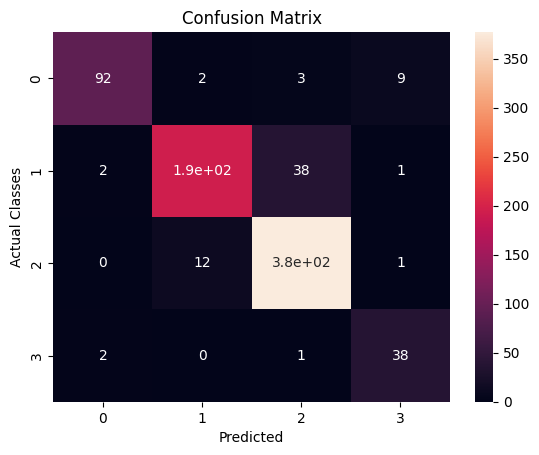

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_dataset.classes

sns.heatmap(confusion_matrix(true_labels, predicted_class), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_class))
print(test_dataset.class_indices)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [29]:
model.save_weights("./DNN_model.weights.h5")

model.save("./DNN_model.keras")


In [30]:
from google.colab import files
files.download("DNN_model.weights.h5")
files.download("DNN_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>